## Style guides (remove before submitting)
1. PEP8 for python: https://peps.python.org/pep-0008
2. for jupyter notebook: https://github.com/spacetelescope/style-guides/blob/master/guides/jupyter-notebooks.md

## Comments style (from pep8)
1. Note: comments are full sentences!
2. Avoid inline comments, especially obvious ones

Dont do:\
x = x + 1                 # Increment x

But sometimes, this is useful:\
x = x + 1                 # Compensate for border

## General TODO (remove before submitting)
1. Maybe add Raise errors?

## DOCSTRING convention example (according to Pep8) (remove before submitting)
**Short docstrings:**\
"""This is an example of a short docstring."""\
\
**Long docstrings:**\
"""\
Short description of the function (may be next to quotations above).\
\
Arguments:\
    parametername: What the parameter is\
    parametername2: what the parameter is\
\
Returns:\
    This is a description of what the function returns.\
"""

# Gillespie's Algorithm and Stochasticity in a SIR model

This code implements a Gillespie's algorithm (GA) to a SIR model where stochasticity is introduced.  

#### SIR Model
A SIR model is a description of the behavioral patterns of infectious disseases with the help of a set of Ordinary Differential Equations (ODEs). Depending on the dissease that's being modeled, there are different types of SIR models that can be implemented. The model that we use is divided into three categories:

1.  Susceptible; A group within the population that is susceptible to infection with the dissease.
2.  Infected; A group within the population that is currently infected with the dissease
3.  Recovered; A group that has recovered from an infection, we assume they cannot be infected again

The rate with which people transfer between these categories is described by parameters. The parameters we use are called the infection rate (beta) and recovery rate (gamma) that describe the flow of susceptible to infected (beta) and of infected to recovered (gamma). Additionally, a birth and death rate (mu) is introduced to describe the effect of 'fresh' additions to the population to the susceptible pool and a chance of mortality at each category.

The set of ODEs describe how the populations within these categories change over time due to the applied parameters. 

- TO DO: 
    - add ODE functions

### Gillespie's Algorithm
A Gillespie's Algorithm (GA) stochastically simulates discrete events from the equation it is applied to. In our application we used the so-called First Reaction Method where the rate at which an event occurs is passed to calculate how long it takes for the event to occur. To this determination, a random variable is attached to add stochasticity. The event that takes the least amount of time to occur is then executed, all other events are negated. The time that passed is updated to include the time it took for the event to occur and a new event is generated. This is repeated until the predetermined end-point is reached (such as an established end-time).

- TO DO: 
    - add GA function 
    - explain what are events in SIR model 







## Imports

The following libraries where imported for further use in the code

* tabulate for ...
* numpy for use in numerical computing
* matplotlib for visualisation of data in plots
* pandas for ...
* fractions for ...
* solve_ivp for numerical integration of the SIR ODE functions
* bisect for ...

- TO DO:
    - Add explanations
    - Remove unused imports

In [2]:
#from tabulate import tabulate
#import pandas as pd
#from fractions import Fraction

import bisect
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.models.DiffusionModel as dm


## Updating SIR model values

During the stochastic GSP function, a key is returned that correlates to the event that takes place; 'infection' indicates a susceptible individual transferring to the infected population. This key will dictate how the different SIR model population are updated. All neccesary SIR values are changed and given back to the GSP function.


In [1]:
def sir_update(S, I, R, N, key):
    """Updates and returns SIRN populations according to given key."""

    if key == 'infection':
        S -= 1
        I += 1
        return S, I, R, N
    
    elif key == 'recovery': 
        R += 1
        I -= 1
        return S, I, R, N
    
    elif key == 'birth':
        S += 1
        N += 1
        return S, I, R, N
    
    elif key == 'death S':
        S -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death I':
        I -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death R':
        R -= 1
        N -= 1
        return S, I, R, N

## The Gillespie Stochastic Model 

This implementation of the GSP first-reaction method calculates the SIR model ODEs but assigns a random variable with 'np.random.exponential'. This random variable will dictate the time it takes for an event, such an infection, to occur. The time for all possible events is calculated and the event that happens first is passed to another function (gsp_update) where all populations are updated. This is repeated until a given endpoint is reached. All changes and the time points at which they occur are recorded. Due to this stochasticity introduced by the random variable, the time points (labelled time_events) and order of events can vary between run.

TO DO
- Add a way to control noise level (gsp function)
    - Larger N reduces noise
    - average results on multiple simulations
    - reduce noise after simultaion: remove high frequency fluctuations

In [3]:
def gsp(sir, beta, gamma, mu, end):
    """
    Simulates disease spread using GA First Reaction Method. While the 
    endpoint has not been reached, the time it takes for each event to 
    occur is calculated.  

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        end: Signifies end point of simulation in time.

    Returns:
        A tuple containing a list of time events and population data 
        over time.
    """

    S, I, R, N = sir
    t = 0
    
    t_events = []
    y_data = []
    
    while t <= end:
        event_queue = {}

        # Events can only occur if there are individuals in the population
        if S > 0 and I > 0 and N > 0:
            dt_infection = np.random.exponential(1/(beta*S*I/N))
            event_queue['infection'] = dt_infection

        if I > 0:
            dt_recovery = np.random.exponential(1/(gamma*I))
            event_queue['recovery'] = dt_recovery

        if N > 0:
            dt_birth = np.random.exponential(1/(mu*N))
            event_queue['birth'] = dt_birth

        if S > 0:
            dt_death_S = np.random.exponential(1/(mu*S))
            event_queue['death S'] = dt_death_S

        if I > 0:
            dt_death_I = np.random.exponential(1/(mu*I))
            event_queue['death I'] = dt_death_I

        if R > 0:
            dt_death_R = np.random.exponential(1/(mu*R))
            event_queue['death R'] = dt_death_R

        # The event that occurs first is stored, other events are omitted.
        sorted_queue = dict(sorted(event_queue.items(), 
                                   key=lambda item: item[1]))
        first_event_key, first_event_time = list(sorted_queue.items())[0]
        
        t += first_event_time
        t_events.append(t)

        # The stored event is updated according to their key and saved.
        S, I, R, N = sir_update(S, I, R, N, first_event_key)
        y_data.append([S, I, R])
    
    return (t_events, y_data)

## Run Stochastic Simulation

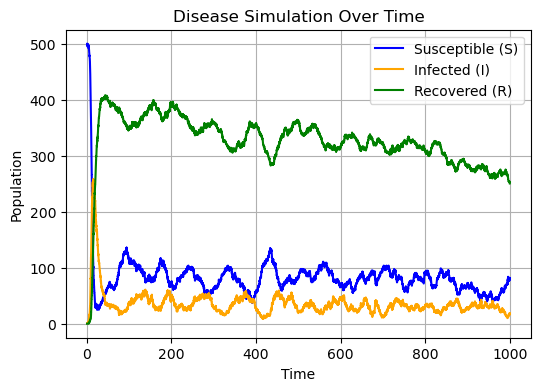

In [4]:
def run_simulation(sir, beta, gamma, mu, t_span):
    """
    Runs the GA stochastic disease simulation and plots the results.

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        t_span: Maximum duration of the GA simulation.
    """

    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)

    y_data = np.array(y_data)

    S = y_data[:, 0]
    I = y_data[:, 1]
    R = y_data[:, 2]

    plt.figure(figsize=(6, 4))
    plt.plot(t_events, S, label='Susceptible (S)', color='blue')
    plt.plot(t_events, I, label='Infected (I)', color='orange')
    plt.plot(t_events, R, label='Recovered (R)', color='green')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Disease Simulation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


# Parameters
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

t_span = 1000

run_simulation(sir, beta, gamma, mu, t_span)

## Run Deterministic Model

To do:

- Add similarity score between stochastic and derministic model.

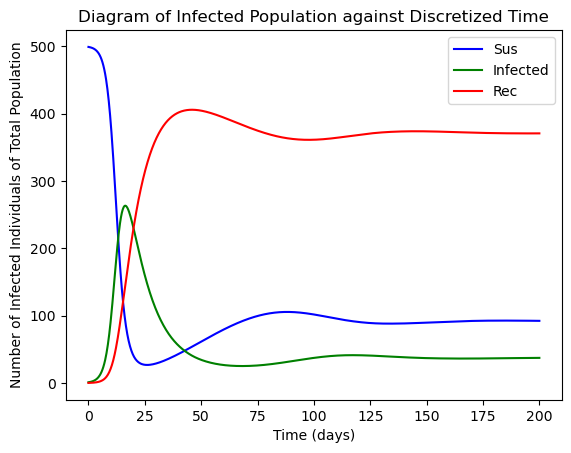

In [5]:
def calc_ode(t, sir, parameters, N):
    """Calculates and returns the change in sir populations over time."""
    
    beta, gamma, mu = parameters
    S, I, R = sir

    dSdt = (mu*N) - ((beta*S*I)/N) - (mu*S)
    dIdt = ((beta*S*I)/N) - (gamma*I) - (mu*I)
    dRdt = (gamma*I) - (mu*R)

    return [dSdt, dIdt, dRdt]


def plot_sir_det(time, S, I, R):
    """Plots the deterministic sir model."""

    plt.plot(time, S, label='Sus', color='b')
    plt.plot(time, I, label='Infected', color='g')
    plt.plot(time, R, label='Rec', color='r')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Infected Population against Discretized Time')
    plt.show()


def run_sir_det(sir, parameters, N, t_span):
    """Runs the deterministic sir model with passed initial values.
    
    Arguments:
        sir: List of S, I, R and N populations.
        parameters: list containg recovery, infection and 
                    birth/death rate
        N: Total initial population
        t_span: Timespan in which the model is ran

    Returns: 
        Timespan used to model sir and population sizes of S, I and R.
    """

    # Time measurement with 1000 samples, equally spaced between 0 and t_span.
    time = np.linspace(0, t_span, 1000)

    sir_integration = solve_ivp(calc_ode, [time[0], time[-1]], sir, 
                                args=(parameters, N), t_eval=time)
    S, I, R = sir_integration.y

    plot_sir_det(time, S, I, R)

    return time, S, I, R


# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

# Intitial population densities
N = 500
S0 = N - 1
I0 = N - S0
R0 = 0
sir_det = [S0, I0, R0]

t_span = 200

# The sem-colon prevents the array from being printed in cell
run_sir_det(sir_det, parameters, N, t_span);

## Look at variance

- Plot results

- Delete print statements (not yet)

- Write correct blockcomments (full sentences) and not too many


Beta/gamma pairs: [(0.410758347329102, 0.15219098886007876), (0.8816486645063204, 0.5196991818606244), (0.2834849349629973, 0.4548345032684429), (0.7116118681563617, 0.33125642270519845), (0.6656164910724965, 0.23973587416181685), (0.48460212237863887, 0.5052819671829298), (0.8130500514559751, 0.22035130798502225), (0.509348764523389, 0.6398839493533106), (0.5263737939964187, 0.2967091925359723), (0.39914876366438756, 0.19403629862299798), (0.555316838753149, 0.27864488104444957), (0.192940713989604, 0.8596875570275835), (0.30443343235661163, 0.27821979904045235), (0.6601999071764061, 0.4236624938193009), (0.5472575409528383, 0.8850626707511436), (0.5423472008465874, 0.6580551691475486), (0.11998151083513786, 0.12993282471480658), (0.17044428083017343, 0.11857589731180625), (0.1265041688609374, 0.7182102170018407), (0.8050319801898627, 0.6739135697764989), (0.5345117097999758, 0.7177215372217551), (0.4008891535563356, 0.570611208013628), (0.42489230008479895, 0.3143675929276625), (0.52

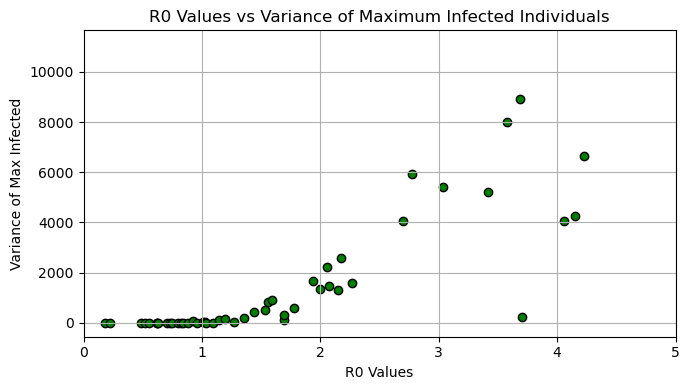

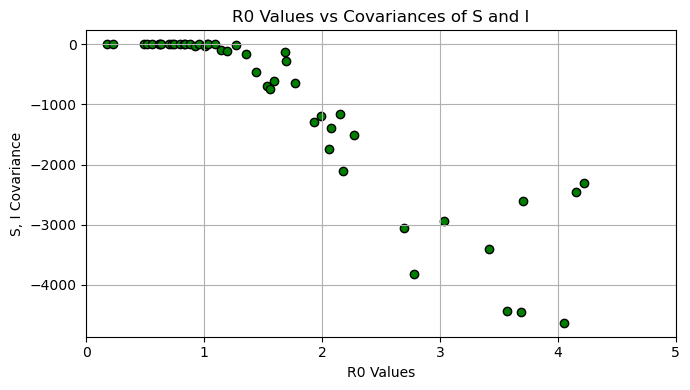

In [6]:
np.random.seed(35)


def generate_parameters(num_samples, lower_ratio=0.45, upper_ratio=0.55, 
                        beta_range=(0.1, 0.9), gamma_range=(0.1, 0.9)):
    """
    Generates beta and gamma pairs randomly to calculate their R0 values. 
    Ensures ratio of R0 values  falls within specified bounds.
    
    Arguments:
        num_samples: Total number of beta/gamma pairs to generate.
        lower_ratio: Lower bound for the ratio of R0 values.
        upper_ratio: Upper bound for the ratio of R0 values.
        beta_range: Range for generated beta values.
        gamma_range: Range for generated gamma values.
    
    Returns:
        A list of the beta gamma pairs and a list of the generated 
        R0 values.
    """
    
    ratio = 0

    while ratio < lower_ratio or ratio > upper_ratio:
        betas = np.random.uniform(beta_range[0], beta_range[1], num_samples)
        gammas = np.random.uniform(gamma_range[0], gamma_range[1], num_samples)

        beta_gamma_pairs = list(zip(betas, gammas))
        R0_vals = [beta/gamma for beta, gamma in beta_gamma_pairs]

        # Calculates the ratio of R0 values < 1 and > 1.
        num_below_one = np.sum(np.array(R0_vals) < 1)
        num_above_one = np.sum(np.array(R0_vals) > 1)
        ratio = num_below_one/(num_above_one + 1e-10)

    R0_vals
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    print("Ratio: " + str(ratio))
    
    return beta_gamma_pairs, R0_vals


def parameter_sweep(sir, pairs, mu, num_runs):
    """
    Performs a parameter sweep over the SIR model simulation to analyze 
    the impact of varying beta and gamma values on the maximum number of 
    infected individuals.

    Arguments:
        sir: List of S, I, R and N populations.
        pairs: List of beta-gamma tuples to test in SIR model.
        mu: Natural birth and death rate.
        num_runs: Number of simulation runs per beta-gamma pair tuples.
    
    Returns:
        A list of variances and covariances of the maximum infected 
        values for each beta-gamma pair.
    """
    
    variances = []
    covariances = []

    for beta, gamma in pairs:
        
        # For variance
        max_I_vals = []

        # For covariance
        S_vals= []
        I_vals = []
        
        # Run simulation n times for each (beta, gamma) pair.
        for _ in range(num_runs):

            result = gsp(sir, beta, gamma, mu, t_span)
            y_data = np.array(result[1])

            S = y_data[:, 0]
            I = y_data[:, 1]
            R = y_data[:, 2]

            S_vals.extend(S)
            I_vals.extend(I)

            # Extract max I value from each run.
            max_I_vals.append(np.max(I))

        # Variance for each (beta, gamma) pair after n runs is recorded.
        variances.append(np.var(max_I_vals))
        covariance_matrix = np.cov(S_vals, I_vals)
        covariances.append(covariance_matrix[0, 1])

    return variances, covariances


def plot_R0_vs_variance(R0_vals, variances):
    """
    Plots R0 values against variances of maximum infected individuals.
    """

    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, variances, color='green', edgecolor='black')

    plt.xlabel('R0 Values')
    plt.ylabel('Variance of Max Infected')
    plt.title('R0 Values vs Variance of Maximum Infected Individuals')
    #plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()


def plot_R0_vs_covariances(R0_vals, covariances):
    """
    Plots R0 values against covariances of S and I across different 
    parameter pairs.
    """

    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, covariances, color='green', edgecolor='black')

    plt.xlabel('R0 Values')
    plt.ylabel('S, I Covariance')
    plt.title('R0 Values vs Covariances of S and I')
    #plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()


# Define number of beta/gamma pairs.
num_pairs = 50

# Define number of runs per beta/gamma pair.
num_runs = 10

# Generate Parameters
sample_pairs, sample_R0_vals = generate_parameters(num_pairs)

# Calculate variances
variances, covariances = parameter_sweep(sir, sample_pairs, mu, num_runs)

# Combine and sort by R0 for variance analysis
var_combined = list(zip(sample_R0_vals, variances))
sorted_var_combined = sorted(var_combined)
sorted_R0_vals, sorted_variances = zip(*sorted_var_combined)

# Combine and sort by R0 for variance analysis
covar_combined = list(zip(sample_R0_vals, covariances))
sorted_covar_combined = sorted(covar_combined)
sorted_R0_vals, sorted_covariances = zip(*sorted_covar_combined)


plot_R0_vs_variance(sorted_R0_vals, sorted_variances)
plot_R0_vs_covariances(sorted_R0_vals, sorted_covariances)

## Calculate the Mean accross multiple runs 
TO DO: change deterministic to roll with same parameters

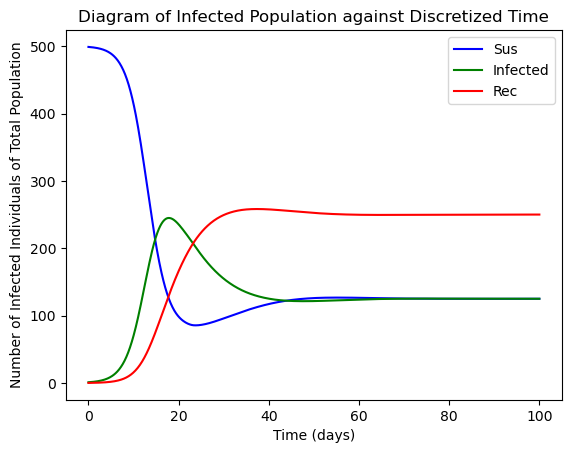

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


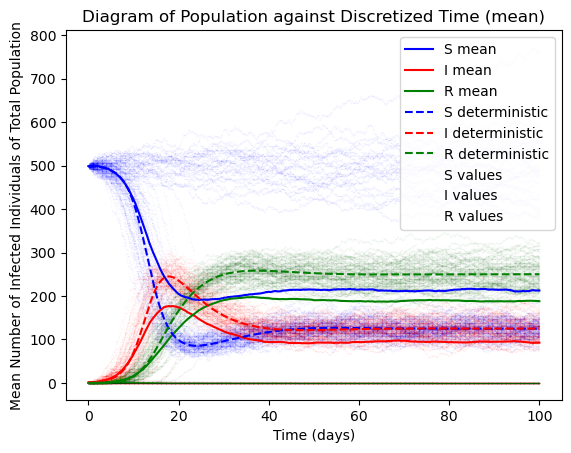

In [7]:
def gsp_mean(runs, t_span, sir, parameters):
    """
    Calculates the mean of a given number of runs of the stochastic sir
    model and calculates the standard deviation of the runs from this
    mean. 

    Arguments:
        runs: Number of times the stochastic model is ran
        t_span: Timespan during which the runs are calculated
        sir: Initial values of S, I and R of the SIR model
        parameters: list of the Infection, recovery and birt rates

    Returns:
        Dictionaries containing data of the stochastic runs, the 
        calculated mean and standard deviation for each population 
        category at specific time points.
    """

    beta, gamma, mu = parameters

    # calculates how large the steps should be in between time steps    
    t_steps = t_span/1000
 
    # end excludes end so include t_steps. steps are spacing between values
    fixed_steps = np.round(np.arange(0, t_span + t_steps, t_steps), 2)

    # store data from run at those fixed time steps 
    results = {
        'time': fixed_steps.tolist(),
        'S': {round(step, 4): [] for step in fixed_steps},
        'I': {round(step, 4): [] for step in fixed_steps},
        'R': {round(step, 4): [] for step in fixed_steps},
        'N': {round(step, 4): [] for step in fixed_steps}
        }
    
    results_mean = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }
    
    results_stdev = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }

    for _ in range(runs):
        # get data from run
        t_events , y_data = gsp(sir, beta, gamma, mu, t_span)

        # finds for which values of steps in fixed_steps what the closest (lower) is in t_events.
        for steps in fixed_steps:

            #round the steps similarly to the dictionary
            steps = round(steps, 4)

            #returns where a value should be inserted
            position_value = bisect.bisect_right(t_events, steps)

            #want lowest closest value position, but position can be 0 or higher than max (t_span)
            if position_value > 0:
                position_value -= 1

            S, I, R = y_data[position_value]

            # Appends the corresponding values to the correct place on the timeline
            results['S'][steps].append(S)
            results['I'][steps].append(I)
            results['R'][steps].append(R)
            results['N'][steps].append(S + I + R)

    #access every fixed step
    # access all entries for S, I , R and N in the fixed steps and store mean values in a dictionary
    for steps in fixed_steps:
        
        results_mean['S'].append(np.mean(results['S'][steps]))
        results_mean['I'].append(np.mean(results['I'][steps]))
        results_mean['R'].append(np.mean(results['R'][steps]))
        results_mean['N'].append(np.mean(results['N'][steps]))

        results_stdev['S'].append(np.std(results['S'][steps]))
        results_stdev['I'].append(np.std(results['I'][steps]))
        results_stdev['R'].append(np.std(results['R'][steps]))
        results_stdev['N'].append(np.std(results['N'][steps]))
    
    return results, results_mean, results_stdev


#mean plus deterministic plus stdev
def plot_mean(results, results_mean, results_stdev, sir):
    """
    Visualisation of the mean of the stochastic model vs the 
    deterministic sir model.
    """
   
    S, I, R, N = sir
    sir_det = [S, I, R]

    S_mean = results_mean['S']
    I_mean = results_mean['I']
    R_mean = results_mean['R']
    time = results['time']

    time_2, S, I, R = run_sir_det(sir_det, parameters, N, t_span)
    
    plt.plot(time, S_mean, label='S mean', color='blue')
    plt.plot(time, I_mean, label='I mean', color='red')
    plt.plot(time, R_mean, label='R mean', color='green')
    plt.plot(time_2, S, label='S deterministic', color='blue', 
             linestyle='dashed')
    plt.plot(time_2, I, label='I deterministic', color='red', 
             linestyle='dashed')
    plt.plot(time_2, R, label='R deterministic', color='green', 
             linestyle='dashed')

    time_steps_S = []
    time_steps_I = []
    time_steps_R = []
    S_values = []
    I_values = []
    R_values = []

    for time_step, values in results['S'].items():
        for value in values:
            time_steps_S.append(time_step)
            S_values.append(value)
    
    for time_step, values in results['I'].items():
        for value in values:
            time_steps_I.append(time_step)
            I_values.append(value)

    for time_step, values in results['R'].items():
        for value in values:
            time_steps_R.append(time_step)
            R_values.append(value)

    plt.scatter(time_steps_S, S_values, alpha=0.03, linewidths=0, 
                color='blue', marker='o', label='S values', s=1)
    plt.scatter(time_steps_I, I_values, alpha=0.03, linewidths=0, 
                color='red', marker='o', label='I values', s=1)
    plt.scatter(time_steps_R, R_values, alpha=0.03, linewidths=0, 
                color='green', marker='o', label='R values', s=1)

    plt.xlabel('Time (days)')
    plt.ylabel('Mean Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Population against Discretized Time (mean)')
    plt.show()

    return


# Initial conditions with a population of 500 people
N = 500
S = N - 1
I = N - S0
R = 0
sir = [S, I, R, N]

beta = 0.6
gamma = 0.1
mu = 0.05
parameters = [beta, gamma, mu]

t_span = 100

runs = 100

results, results_mean, results_stdev = gsp_mean(runs, t_span, sir, parameters)
plot_mean(results, results_mean, results_stdev, sir)

## R0 vs Extinction Events

Beta/gamma pairs: [(0.11000000000000001, 0.1), (0.13052631578947368, 0.1), (0.15105263157894738, 0.1), (0.17157894736842105, 0.1), (0.19210526315789475, 0.1), (0.21263157894736848, 0.1), (0.23315789473684215, 0.1), (0.25368421052631585, 0.1), (0.2742105263157895, 0.1), (0.2947368421052632, 0.1), (0.3152631578947369, 0.1), (0.3357894736842106, 0.1), (0.35631578947368425, 0.1), (0.3768421052631579, 0.1), (0.3973684210526316, 0.1), (0.4178947368421053, 0.1), (0.438421052631579, 0.1), (0.45894736842105266, 0.1), (0.47947368421052633, 0.1), (0.5, 0.1)]
R0 values: [1.1        1.30526316 1.51052632 1.71578947 1.92105263 2.12631579
 2.33157895 2.53684211 2.74210526 2.94736842 3.15263158 3.35789474
 3.56315789 3.76842105 3.97368421 4.17894737 4.38421053 4.58947368
 4.79473684 5.        ]
0.0
0.7647058823529411
0.3333333333333333
0.0
0.125
0.6666666666666666
0.0
0.0
0.0
0.07142857142857142
3.7142857142857144
0.07142857142857142
0.0
0.0
0.16666666666666666
0.0
0.0
0.0
0.48
0.0
0.25
0.0
0.0
0.0
10

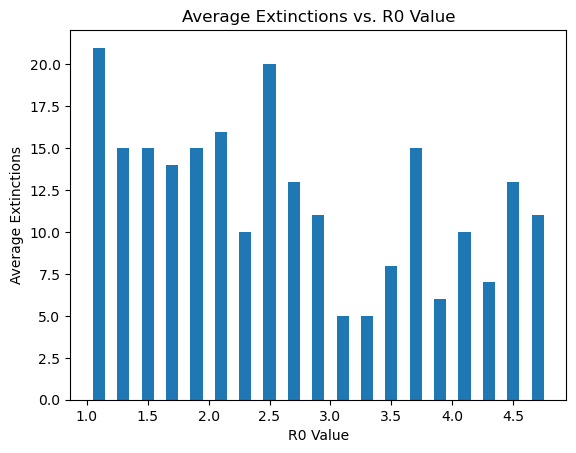

In [8]:
def generate_large_R0(num_samples, R0_range=(1.1, 5), gamma_value=0.1):
    """
    Systemically generates beta and gamma pairs for an R0 value range 
    between 1.1 and 5.
    
    Parameters:
        num_samples: Number of beta and gamma pairs to generate.
        R0_range: Range for R0 values.
        gamma_value: Fixed value for gamma for which beta is calculated.
    
    Returns:
        list: List of (beta, gamma) pairs.
        list: List of R0 values.
    """
    
    # Generate evenly spaced R0 values within the specified range
    R0_vals = np.linspace(R0_range[0], R0_range[1], num_samples)
    
    # Use a fixed gamma value, and calculate corresponding beta = R0 * gamma
    gammas = np.full(num_samples, gamma_value)
    betas = R0_vals*gammas  # beta = R0 * gamma

    beta_gamma_pairs = list(zip(betas, gammas))

    # Optional: print for debugging
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    
    return beta_gamma_pairs, R0_vals


def count_R0_extinctions(pairs, num_runs):

    extinction_list = []

    for beta, gamma in pairs:
    
        num_extinctions = 0
    
        for _ in range(num_runs):


                result = gsp(sir, beta, gamma, mu, t_span)
                y_data = np.array(result[1])

                I = y_data[:, 1]

                mean = np.mean(I)

                print(mean)


                if mean < 1e-2:  # Treat any value below a small threshold as extinction:
                    
                    num_extinctions += 1

                
        
        extinction_list.append(num_extinctions)

    
    return extinction_list
        

def plot_results_R0(num_pairs, num_runs):
    
    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)
    R0_extinctions = count_R0_extinctions(sample_pairs, num_runs)

    # Sort R0 values and corresponding extinctions
    R0_extinction_pairs = list(zip(sample_R0_vals, R0_extinctions))
    sorted_R0_extinction_pairs = sorted(R0_extinction_pairs)

    sorted_R0_vals, sorted_extinctions = zip(*sorted_R0_extinction_pairs)

    # Convert to numpy arrays for easy indexing
    sorted_R0_vals = np.array(sorted_R0_vals)
    sorted_extinctions = np.array(sorted_extinctions)

    # Bin the R0 values (for example, in intervals of 0.1)
    bins = np.arange(min(sorted_R0_vals), max(sorted_R0_vals), 0.2)
    bin_indices = np.digitize(sorted_R0_vals, bins)

    # Average extinctions within each bin
    binned_extinctions = [np.mean(sorted_extinctions[bin_indices == i]) 
                          for i in range(1, len(bins))]

    # Plotting
    plt.bar(bins[:-1], binned_extinctions, width=0.1)
    plt.xlabel("R0 Value")
    plt.ylabel("Average Extinctions")
    plt.title("Average Extinctions vs. R0 Value")
    plt.show()


num_pairs = 20
num_runs = 50
mu = 0.0001

plot_results_R0(num_pairs, num_runs)

## N vs Extinction Events

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


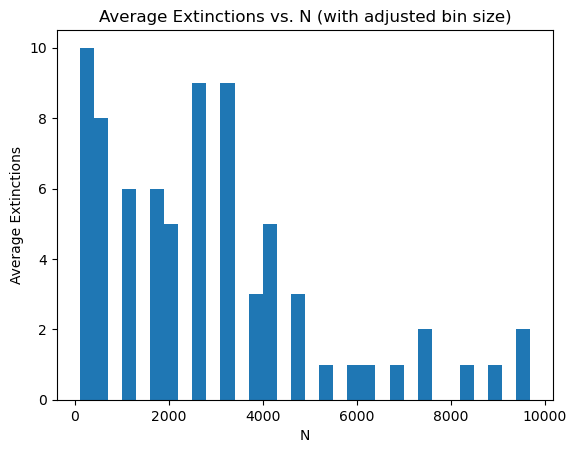

In [9]:
def generate_populations(num_pops):
    populations = []
    
    # Evenly distribute populations from 100 to 10,000
    S_0 = np.linspace(100, 10000, num_pops)

    for i in range(num_pops):
        S = S_0[i]
        I = 1
        R = 0
        N = S + I
        sir = (S, I, R, N)
        populations.append(sir)
    
    return populations


def count_N_extinctions(num_pops, num_runs):
    populations = generate_populations(num_pops)
    extinction_list = []

    for pop in populations:
        num_extinctions = 0
        for _ in range(num_runs):
            result = gsp(pop, beta, gamma, mu, t_span)
            y_data = np.array(result[1])
            I = y_data[:, 1]
            mean = np.mean(I)

            # Treat any value below a small threshold as extinction:
            if mean < 1e-3:
                num_extinctions += 1
        
        extinction_list.append(num_extinctions)
    
    return extinction_list


def plot_results_N(num_pops, num_runs):
    sample_pops = generate_populations(num_pops)
    N_extinctions = count_N_extinctions(num_pops, num_runs)

    # Sort population sizes and corresponding extinctions
    N_extinction_pairs = list(zip(sample_pops, N_extinctions))
    sorted_N_extinction_pairs = sorted(N_extinction_pairs)

    sorted_pops, sorted_extinctions = zip(*sorted_N_extinction_pairs)

    # Convert to numpy arrays for easy indexing
    sorted_pops = np.array(sorted_pops)
    sorted_extinctions = np.array(sorted_extinctions)

    # Bin the population sizes more sensibly with a larger bin size
    bins = np.arange(min(sorted_pops[:, 0]), max(sorted_pops[:, 0]) + 1, 300)  # Increase bin size to 1000
    bin_indices = np.digitize(sorted_pops[:, 0], bins)

    # Average extinctions within each bin
    binned_extinctions = [np.mean(sorted_extinctions[bin_indices == i]) for i in range(1, len(bins))]

    # Plotting
    plt.bar(bins[:-1], binned_extinctions, width=np.diff(bins), align='edge')
    plt.xlabel("N")
    plt.ylabel("Average Extinctions")
    plt.title("Average Extinctions vs. N (with adjusted bin size)")
    plt.show()


# Parameters
beta = 0.4
gamma = 0.1
mu = 0.0001

num_pops = 20
num_runs = 50

plot_results_N(num_pops, num_runs)

## Extinctions as a Function of R0 and N

In [10]:
def plot_results_R0_N(num_pairs, num_pops, num_runs):
    # Generate R0 pairs
    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)

    # Generate populations
    populations = generate_populations(num_pops)

    # Count extinctions for each combination of R0 and N
    extinction_data = []

    for (beta, gamma), R0 in zip(sample_pairs, sample_R0_vals):
        
        for pop in populations:
            num_extinctions = 0
            
            for _ in range(num_runs):
                result = gsp(pop, beta, gamma, mu, t_span)
                y_data = np.array(result[1])
                I = y_data[:, 1]
                mean = np.mean(I)
                
                if mean < 1e-2:  # Treat any value below a small threshold as extinction
                    num_extinctions += 1

            # Store results: (N, R0, num_extinctions)
            N = pop[0] + pop[1] + pop[2]  # S + I + R
            extinction_data.append((N, R0, num_extinctions))

    # Convert to numpy array for easier indexing
    extinction_data = np.array(extinction_data)

    # Separate the data for plotting
    N_values = extinction_data[:, 0]
    R0_values = extinction_data[:, 1]
    extinction_counts = extinction_data[:, 2]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(N_values, R0_values, extinction_counts, c=extinction_counts, cmap='viridis')
    
    ax.set_xlabel('Population Size (N)')
    ax.set_ylabel('R0 Value')
    ax.set_zlabel('Number of Extinctions')
    ax.set_title('Interaction between R0 and N in Extinctions')
    
    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Number of Extinctions')

    plt.show()

# Parameters
num_pairs = 20
num_pops = 20
num_runs = 20
mu = 0.0001

# Execute the plotting function
plot_results_R0_N(num_pairs, num_pops, num_runs)

Beta/gamma pairs: [(0.11000000000000001, 0.1), (0.11795918367346941, 0.1), (0.1259183673469388, 0.1), (0.1338775510204082, 0.1), (0.14183673469387756, 0.1), (0.14979591836734696, 0.1), (0.15775510204081633, 0.1), (0.16571428571428573, 0.1), (0.17367346938775513, 0.1), (0.1816326530612245, 0.1), (0.1895918367346939, 0.1), (0.1975510204081633, 0.1), (0.20551020408163267, 0.1), (0.21346938775510207, 0.1), (0.22142857142857145, 0.1), (0.22938775510204082, 0.1), (0.2373469387755102, 0.1), (0.24530612244897962, 0.1), (0.25326530612244896, 0.1), (0.2612244897959184, 0.1), (0.26918367346938776, 0.1), (0.27714285714285714, 0.1), (0.2851020408163265, 0.1), (0.29306122448979594, 0.1), (0.3010204081632653, 0.1), (0.30897959183673473, 0.1), (0.3169387755102041, 0.1), (0.3248979591836735, 0.1), (0.3328571428571429, 0.1), (0.3408163265306123, 0.1), (0.34877551020408165, 0.1), (0.3567346938775511, 0.1), (0.36469387755102045, 0.1), (0.3726530612244898, 0.1), (0.3806122448979592, 0.1), (0.38857142857142

KeyboardInterrupt: 

## Stochastic Resonance

In [1]:
# ratio of output deterministic vs stochastic on y-axis
    # do we want stochastic mean (+error st dev) or singular output
    # peak intensity measure time or how many infected

# x-axis shows difference in parameter 
    # which parameter?

# 

## Mean for different N populations

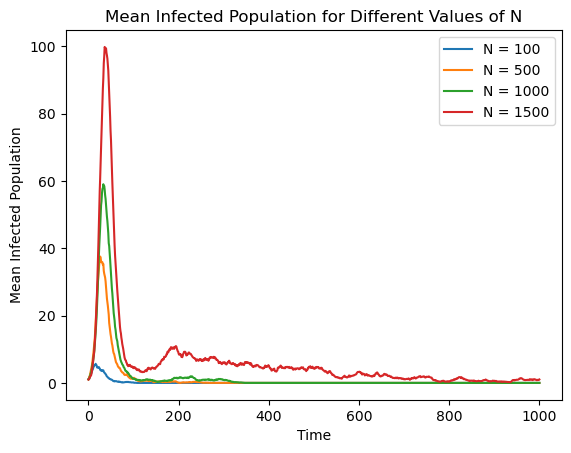

In [16]:
def plot_means_for_different_Ns(N_values, num_runs, t_span, parameters):
    for N in N_values:
        # Generate initial conditions based on N
        sir = (N - 1, 1, 0, N)  # S, I, R, N

        # Get results for the current N
        _, results_mean, _ = gsp_mean(num_runs, t_span, sir, parameters)

        # Plot the mean infected population over time
        plt.plot(results_mean['I'], label=f'N = {N}')

    plt.xlabel('Time')
    plt.ylabel('Mean Infected Population')
    plt.title('Mean Infected Population for Different Values of N')
    plt.legend()
    plt.show()

N_values = [100, 500, 1000, 1500]  # Example N values
num_runs = 50
t_span = 1000
beta = 0.4
gamma = 0.2
mu = 0.01

parameters = (beta, gamma, mu)

plot_means_for_different_Ns(N_values, num_runs, t_span, parameters)

## Barabasi Albert Network

In [3]:
def barabasi_albert(N, m, beta, gamma, I0, t_span):

    
    ba_graph = nx.barabasi_albert_graph(N, m)

  
    model = ep.SIRModel(ba_graph)

    
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)  # Infection rate
    config.add_model_parameter('gamma', gamma)  # Recovery rate
    config.add_model_parameter("fraction_infected", I0)  # Initial fraction infected

    model.set_initial_status(config)

    # Simulate the model
    iterations = model.iteration_bunch(t_span)

    # Extract number of S, I, R nodes for each iteration
    y_data = []  # List to hold S, I, R counts for each iteration

    for iteration in iterations:
        # Get the status of nodes
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:  # Susceptible
                S_count += 1
            elif state == 1:  # Infected
                I_count += 1
            elif state == 2:  # Recovered
                R_count += 1
        
        # Append counts to the list
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts



    






def ba_parameter_sweep(N, m, beta, gamma, I0,  num_runs, num_pairs):

    pairs = generate_parameters(num_pairs)

    for pair in pairs:
        

        beta, gamma = pair

        iterations, y_data = barabasi_albert(N, m, beta, gamma, I0,  num_runs)

        # Extract number of S, I, R nodes for each iteration
    y_data = []  # List to hold S, I, R counts for each iteration

    for iteration in iterations:
        # Get the status of nodes
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:  # Susceptible
                S_count += 1
            elif state == 1:  # Infected
                I_count += 1
            elif state == 2:  # Recovered
                R_count += 1
        
        # Append counts to the list
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts


    
# Number of nodes
N = 1000

# Number of edges for a new node
m = 5     

beta = 0.3
gamma = 0.1
I0 = 0.05

t_span = 200


## Watts-Strogatz

In [4]:

def watts_strogatz(N, k, p, beta, gamma, I0, t_span):

    ws_graph = nx.watts_strogatz_graph(N, k, p)

    # Configure the diffusion model (e.g., SIR)
    model = ep.SIRModel(ws_graph)

    # Model configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)  # Infection rate
    config.add_model_parameter('gamma', gamma)  # Recovery rate
    config.add_model_parameter("fraction_infected", I0)  # Initial fraction infected

    model.set_initial_status(config)

    # Simulate the model
    iterations = model.iteration_bunch(t_span)
    
    # Extract number of S, I, R nodes for each iteration
    y_data = []  # List to hold S, I, R counts for each iteration

    for iteration in iterations:
        # Get the status of nodes
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:  # Susceptible
                S_count += 1
            elif state == 1:  # Infected
                I_count += 1
            elif state == 2:  # Recovered
                R_count += 1
        
        # Append counts to the list
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts

N = 1000  # Number of nodes
k = 6     # Each node is joined with its k nearest neighbors in a ring topology
p = 0.1   # Rewiring probability

t_span = 200

results = watts_strogatz(N, k, p, beta, gamma, I0, t_span)
print(results)

([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 1, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 1, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 1, 83: 0, 84: 0, 85: 1, 86: 0, 87: 1, 88: 1, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 1, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 1, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 1, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 

## Erdos-Reyni

In [5]:
def erdos_reyni(N, p, beta, gamma, I0, t_span):
    
    # Construct E-R Network
    er_graph = nx.erdos_renyi_graph(N, p)

    model = ep.SIRModel(er_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)  
    config.add_model_parameter('gamma', gamma)  
    config.add_model_parameter("fraction_infected", I0)  

    model.set_initial_status(config)

    # Simulate the model
    iterations = model.iteration_bunch(t_span)

    # Extract number of S, I, R nodes for each iteration
    y_data = []  # List to hold S, I, R counts for each iteration

    for iteration in iterations:
        # Get the status of nodes
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:  # Susceptible
                S_count += 1
            elif state == 1:  # Infected
                I_count += 1
            elif state == 2:  # Recovered
                R_count += 1
        
        # Append counts to the list
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts



N = 1000  # Number of nodes
p = 0.01  # Probability for edge creation
t_span = 200

results = erdos_reyni(N, p, beta, gamma, I0, t_span)
print(results)

([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 1, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 1, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 1, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 1, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 1, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 

## Run SIR on Random (Erdos-Reyni) Network

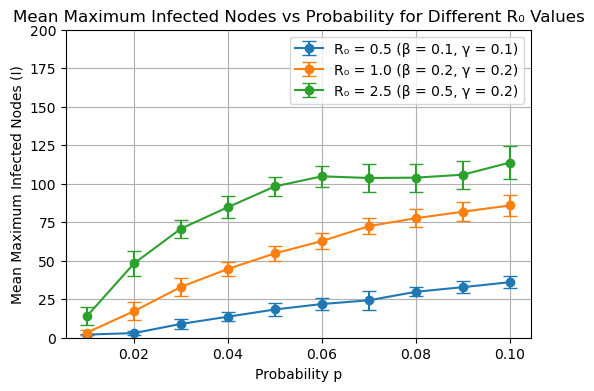

In [30]:
def er_probability_sweep(N, probabilities, beta, gamma, I0, t_span, num_runs):
    mean_max_values = []  # Store mean of maximum infected values
    std_max_values = []   # Store standard deviation of maximum infected values

    for p in probabilities:
        max_I_values = []  # Collect maximum infected values for each run
        
        for _ in range(num_runs):  
            _, y_data = erdos_reyni(N, p, beta, gamma, I0, t_span)
            
            # Extract infected node counts (I) for each iteration in the current run
            I_values = [data['I'] for data in y_data]
            
            # Get the maximum infected value in the current run
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        # Calculate the mean and standard deviation of the max I values for this probability
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
        # Append the results
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values  # Return both means and std deviations



def plot_er_prob_sweep(N, probabilities, beta_values, gamma_values, I0, t_span, num_runs):
    plt.figure(figsize=(6, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        
        mean_max_values, std_max_values = er_probability_sweep(N, probabilities, beta, gamma, I0, t_span, num_runs)
        
        R0 = beta / gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(probabilities, mean_max_values, yerr=std_max_values, fmt='-o', capsize=5, label=label)
    
    plt.xlabel("Probability p") 
    plt.ylabel("Mean Maximum Infected Nodes (I)")
    plt.title("Mean Maximum Infected Nodes vs Probability for Different R₀ Values")
    plt.legend()  
    plt.grid(True)
    plt.ylim(0, N)  
    plt.show()


def er_prob_vs_R0(N, probabilities, I0, t_span, num_runs, R0_values, gamma_values):
    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    
    plot_er_prob_sweep(N, probabilities, beta_values, gamma_values, I0, t_span, num_runs)




# Example Usage
N = 200
probabilities = np.linspace(0.01, 0.1, 10)  # Focus around threshold for connected graph
R0_values = [0.5, 1.0, 2.5]  # Different epidemic thresholds
gamma_values = [0.1, 0.2, 0.2]  # Fix recovery rate, vary infection rate based on R0
I0 = 0.01
t_span = 50
num_runs = 50

er_prob_vs_R0(N, probabilities, I0, t_span, num_runs, R0_values, gamma_values)






        
